In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"parthgoyal08","key":"2b87f00d77e3c53b1841c26b890fe64f"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ipythonx/wikiart-gangogh-creating-art-gan

Dataset URL: https://www.kaggle.com/datasets/ipythonx/wikiart-gangogh-creating-art-gan
License(s): copyright-authors
100% 34.6G/34.6G [16:40<00:00, 23.6MB/s]
100% 34.6G/34.6G [16:40<00:00, 37.2MB/s]


In [ ]:
!unzip wikiart-gangogh-creating-art-gan.zip -d /content/dataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/images/still-life/55bcc9e1b914c4490f320b65efc91736c.jpg  
  inflating: /content/dataset/images/still-life/560140270766ce421fb8e6fdfc5d649ec.jpg  
  inflating: /content/dataset/images/still-life/562843932429acb8192900b1816d65bcc.jpg  
  inflating: /content/dataset/images/still-life/563e3706fd8258dfc750d91a11ef2cd8c.jpg  
  inflating: /content/dataset/images/still-life/56412c99702c33952475a32c962dcff0c.jpg  
  inflating: /content/dataset/images/still-life/5674ea7a997a3fae603e2cc3844aa808c.jpg  
  inflating: /content/dataset/images/still-life/5675cdb5e9488e298e1686bad3f60b46c.jpg  
  inflating: /content/dataset/images/still-life/567fcef3ee874b44e8bb5066839f581bc.jpg  
  inflating: /content/dataset/images/still-life/56826a3d23df262fca95687eaf755bbac.jpg  
  inflating: /content/dataset/images/still-life/568cc91147ad915386e1a9fcbf58d386c.jpg  
  inflating: /content/dataset/images/still-life/5698d9c5d5b1e40b97e12

In [ ]:
import os
import random
import shutil

# Define source and destination directories
src_dir = '/content/dataset/images/abstract'
dest_dir = '/content/sample_data'

# Create destination directory
os.makedirs(dest_dir, exist_ok=True)

# Get list of image files
all_images = os.listdir(src_dir)
sample_size = 5000  # Adjust based on available storage

# Randomly sample images
sampled_images = random.sample(all_images, sample_size)

# Copy sampled images to destination directory
for img in sampled_images:
    shutil.copy(os.path.join(src_dir, img), dest_dir)


In [ ]:
import os
from PIL import Image, UnidentifiedImageError

image_size = (64, 64)  # Smaller size to save space and computation

src_dir = '/content/sample_data'
resized_dir = '/content/resized_data'

# Create directory to save resized images
os.makedirs(resized_dir, exist_ok=True)

# Only include image files
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.gif')
image_paths = [f for f in os.listdir(src_dir) if f.lower().endswith(image_extensions)]

for img_name in image_paths:
    img_path = os.path.join(src_dir, img_name)
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize(image_size, Image.LANCZOS)
        img.save(os.path.join(resized_dir, img_name), optimize=True, quality=85)  # Save with compression
    except (IOError, UnidentifiedImageError) as e:
        print(f"Cannot process {img_name}: {e}")


In [ ]:
import shutil

# Delete the original sampled images to free up space
shutil.rmtree('/content/sample_data')


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)  # None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(4, 4), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 64, 64, 3)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(4, 4), padding='same', input_shape=[64, 64, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(4, 4), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()


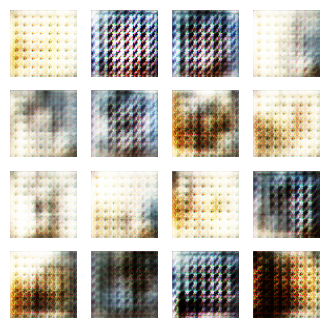

In [ ]:
import numpy as np
import glob
import matplotlib.pyplot as plt

# Load and preprocess images
def load_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0,1]
    image = (image - 0.5) * 2  # Normalize to [-1,1]
    return image

image_files = glob.glob('/content/resized_data/*.jpg')
dataset = tf.data.Dataset.from_tensor_slices(image_files)
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # Real images labeled as 1
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # Fake images labeled as 0
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # Generator wants discriminator to classify fake images as real (label=1)
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

import time
from IPython import display

EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Seed for generating images
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Checkpoint to save models
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

@tf.function
def train_step(images):
    noise = tf.random.normal([64, noise_dim])  # Batch size of 64

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            train_step(image_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] * 0.5 + 0.5))  # Rescale to [0,1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

train(dataset, EPOCHS)

In [ ]:
import os
import random
import shutil

# Define source directories for each style
styles = ['abstract', 'animal-painting', 'cityscape', 'figurative', 'flower-painting', 'genre-painting', 'landscape', 'marina', 'mythological-painting', 'nude-painting-nu', 'portrait', 'religious-painting', 'still-life', 'symbolic-painting']  # Modify based on available styles
src_root_dir = '/content/dataset/images'

dest_dir = '/content/conditional_data'
os.makedirs(dest_dir, exist_ok=True)

sample_size_per_style = 100  # Adjust based on available storage and number of styles

style_to_label = {}  # Map style names to labels

for idx, style in enumerate(styles):
    src_dir = os.path.join(src_root_dir, style)
    style_images = os.listdir(src_dir)

    # Ensure sample size does not exceed available images
    sample_size = min(sample_size_per_style, len(style_images))
    sampled_images = random.sample(style_images, sample_size)

    # Create a directory for each style in the destination
    style_dest_dir = os.path.join(dest_dir, style)
    os.makedirs(style_dest_dir, exist_ok=True)

    for img in sampled_images:
        shutil.copy(os.path.join(src_dir, img), style_dest_dir)

    style_to_label[style] = idx  # Assign a label to each style

print("Style to Label Mapping:", style_to_label)


Style to Label Mapping: {'abstract': 0, 'animal-painting': 1, 'cityscape': 2, 'figurative': 3, 'flower-painting': 4, 'genre-painting': 5, 'landscape': 6, 'marina': 7, 'mythological-painting': 8, 'nude-painting-nu': 9, 'portrait': 10, 'religious-painting': 11, 'still-life': 12, 'symbolic-painting': 13}


In [ ]:
import pandas as pd
from PIL import Image

image_size = (64, 64)
data_records = []

for style in styles:
    src_dir = os.path.join(dest_dir, style)
    image_names = os.listdir(src_dir)
    for img_name in image_names:
        img_path = os.path.join(src_dir, img_name)
        # Resize image
        img = Image.open(img_path).convert('RGB')
        img = img.resize(image_size, Image.LANCZOS)  # Updated line
        img.save(img_path, optimize=True, quality=85)
        # Record the image path and style label
        data_records.append((img_path, style_to_label[style]))

# Create a DataFrame and save to CSV
df = pd.DataFrame(data_records, columns=['image_path', 'label'])
df.to_csv('/content/data_labels.csv', index=False)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/data_labels.csv')
image_paths = df['image_path'].values
labels = df['label'].values
num_classes = len(style_to_label)

def load_image_with_label(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)  # [0,1]
    image = (image - 0.5) * 2  # [-1,1]
    return image, label

# Create a dataset from image paths and labels
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(lambda x, y: load_image_with_label(x, y), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)


In [ ]:
def make_generator_model():
    noise = layers.Input(shape=(100,))
    label = layers.Input(shape=(1,), dtype='int32')

    # Embed and flatten the label
    label_embedding = layers.Embedding(num_classes, 50)(label)
    label_embedding = layers.Flatten()(label_embedding)

    # Concatenate noise and label embedding
    model_input = layers.Concatenate()([noise, label_embedding])

    x = layers.Dense(8*8*256, use_bias=False)(model_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Reshape((8, 8, 256))(x)
    assert x.shape == (None, 8, 8, 256)

    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
    assert x.shape == (None, 8, 8, 128)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    assert x.shape == (None, 16, 16, 64)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(3, (5, 5), strides=(4, 4), padding='same', use_bias=False, activation='tanh')(x)
    assert x.shape == (None, 64, 64, 3)

    generator = tf.keras.Model([noise, label], x)
    return generator

def make_discriminator_model():
    image = layers.Input(shape=(64, 64, 3))
    label = layers.Input(shape=(1,), dtype='int32')

    # Embed and reshape the label to match image dimensions
    label_embedding = layers.Embedding(num_classes, 50)(label)
    label_embedding = layers.Dense(64 * 64)(label_embedding)
    label_embedding = layers.Reshape((64, 64, 1))(label_embedding)

    # Concatenate image and label embedding
    x = layers.Concatenate(axis=-1)([image, label_embedding])

    x = layers.Conv2D(64, (5, 5), strides=(4, 4), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(4, 4), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    discriminator = tf.keras.Model([image, label], x)
    return discriminator

# Re-instantiate the models
generator = make_generator_model()
discriminator = make_discriminator_model()

# Now instantiate the optimizers AFTER redefining the models
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Set up the checkpoint AFTER re-instantiating the optimizers
checkpoint_dir = '/content/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Ensure labels are of type int32 and shape (batch_size, 1)
labels = labels.astype('int32')
labels = labels.reshape(-1, 1)

# Update the dataset creation
dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
dataset = dataset.map(lambda x, y: load_image_with_label(x, y), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000).batch(64).prefetch(tf.data.AUTOTUNE)


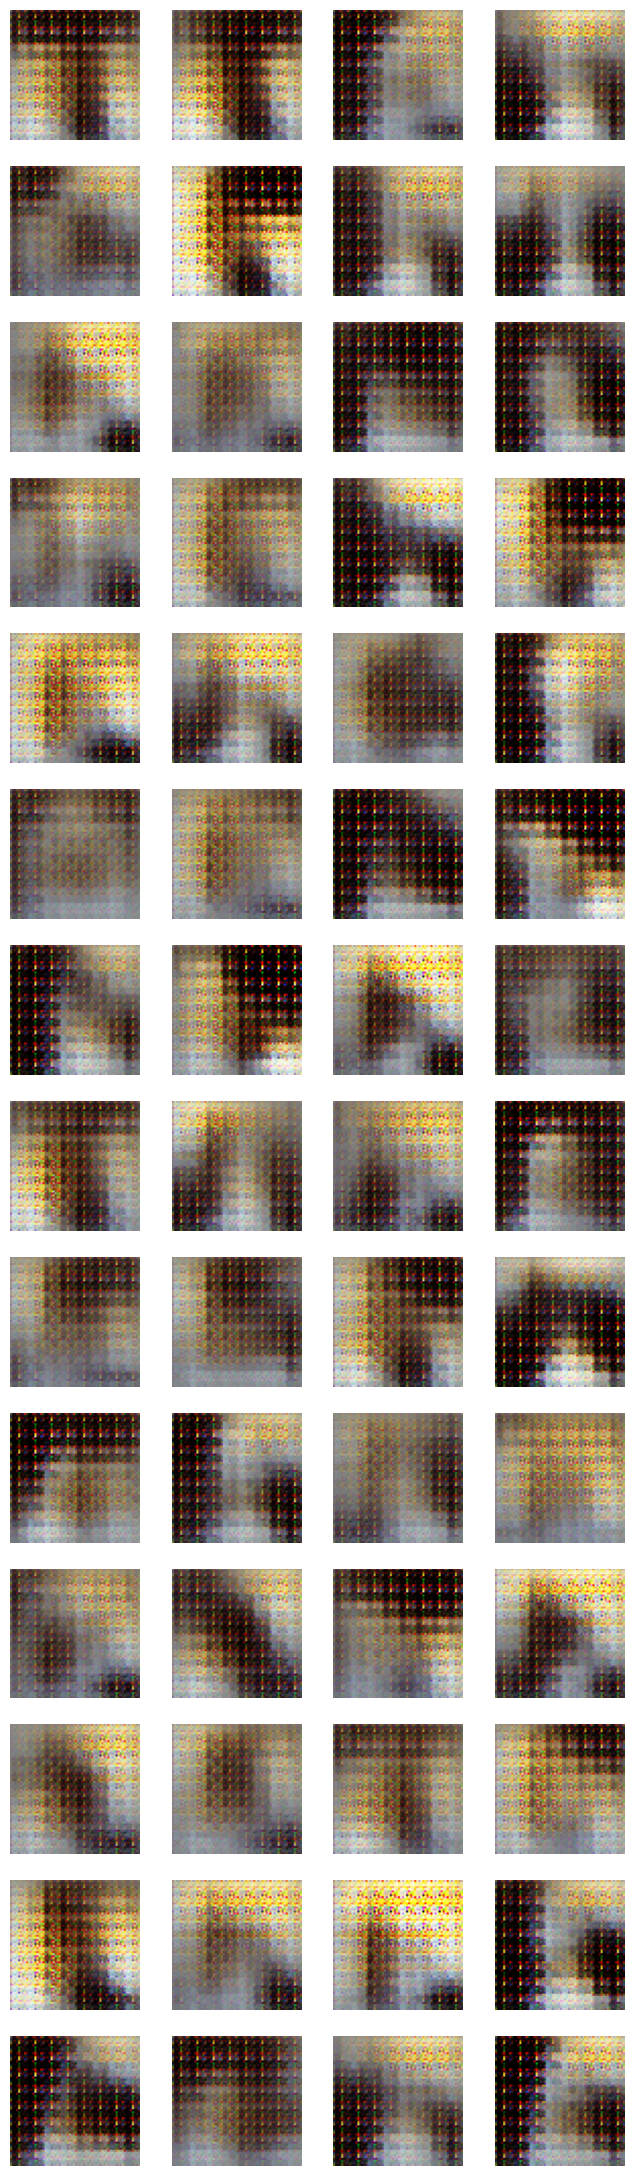

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
from IPython import display

@tf.function
def train_step(images, labels):
    batch_size = images.shape[0]
    noise = tf.random.normal([batch_size, noise_dim])
    labels = tf.cast(labels, tf.int32)  # Ensure labels are int32

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, labels], training=True)

        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Calculate gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for image_batch, label_batch in dataset:
            train_step(image_batch, label_batch)

        # Generate and save images at the end of each epoch
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed, labels_for_seed)

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        print(f'Time for epoch {epoch + 1} is {time.time() - start} sec')

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed, labels_for_seed)

# Seed for generating images
num_examples_to_generate = num_classes * 4  # For example, 4 images per class
seed = tf.random.normal([num_examples_to_generate, noise_dim])

# Labels corresponding to the seed
labels_for_seed = []
for i in range(num_classes):
    labels_for_seed.extend([i] * 4)  # 4 examples per class
labels_for_seed = tf.convert_to_tensor(labels_for_seed, dtype=tf.int32)
labels_for_seed = labels_for_seed[:, tf.newaxis]

def generate_and_save_images(model, epoch, test_input, test_labels):
    predictions = model([test_input, test_labels], training=False)

    num_rows = num_classes
    num_cols = predictions.shape[0] // num_classes
    fig = plt.figure(figsize=(num_cols * 2, num_rows * 2))

    for i in range(predictions.shape[0]):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow((predictions[i] * 0.5 + 0.5))  # Rescale to [0,1]
        plt.axis('off')

    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()

train(dataset, EPOCHS)


In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existi

In [ ]:
# Reload the latest generator checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
import gradio as gr

def generate_art(style_name, seed):
    # Convert style name to label
    style_label = style_to_label[style_name]
    style_label = tf.convert_to_tensor([[style_label]], dtype=tf.int32)

    # Generate noise vector with the provided seed
    tf.random.set_seed(seed)
    noise = tf.random.normal([1, noise_dim])

    # Generate image
    generated_image = generator([noise, style_label], training=False)
    generated_image = (generated_image[0] * 0.5 + 0.5).numpy()  # Rescale to [0,1]

    return generated_image


In [ ]:
interface = gr.Interface(
    fn=generate_art,
    inputs=[
        gr.Dropdown(choices=list(style_to_label.keys()), label="Style"),
        gr.Slider(minimum=0, maximum=1000, step=1, label="Seed")
    ],
    outputs="image",
    title="AI-Powered Art Generator",
    description="Generate unique artwork based on style and random seed."
)

interface.launch(debug=True)


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://d1dd2bf46f9af5e3b5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# Mount Google Drive and save your project in one cell

# Import necessary libraries
from google.colab import drive
import shutil
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the paths
project_folder = '/content/drive/MyDrive/AI_Art_Generator'

# Create the project folder if it doesn't exist
os.makedirs(project_folder, exist_ok=True)

# Save your models
generator_save_path = os.path.join(project_folder, 'generator.h5')
discriminator_save_path = os.path.join(project_folder, 'discriminator.h5')

generator.save(generator_save_path)
discriminator.save(discriminator_save_path)

# Save your checkpoints (if using TensorFlow checkpoints)
checkpoint_dir = os.path.join(project_folder, 'training_checkpoints')
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

os.makedirs(checkpoint_dir, exist_ok=True)

# Adjust the checkpoint to save to Google Drive
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Save the latest checkpoint
checkpoint.save(file_prefix=checkpoint_prefix)

# Save your preprocessed data labels (if applicable)
data_labels_path = os.path.join(project_folder, 'data_labels.csv')
df.to_csv(data_labels_path, index=False)

# Optionally, save your preprocessed image data
# For example, copy the 'resized_data' directory to Google Drive
resized_data_src = '/content/resized_data'  # Your preprocessed data directory
resized_data_dest = os.path.join(project_folder, 'resized_data')

# Check if the directory exists to avoid copying if not necessary
if os.path.exists(resized_data_src):
    # Remove existing directory in Drive to avoid duplication
    if os.path.exists(resized_data_dest):
        shutil.rmtree(resized_data_dest)
    shutil.copytree(resized_data_src, resized_data_dest)

print("Your project has been saved to Google Drive.")
